In [2]:
from slab_dataset import get_linear_data, get_nonlinear_data, get_slab_data
from sklearn.model_selection import train_test_split

X_nonlinear, Y_nonlinear = get_nonlinear_data(30)
X_linear, Y_linear = get_linear_data(30)
X_train, X_test, Y_train, Y_test = train_test_split(*get_slab_data(), test_size=200, random_state=42)

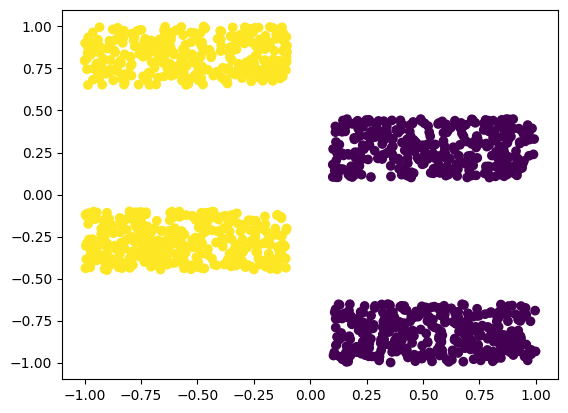

In [3]:
import matplotlib.pyplot as plt

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)

## Guess and check

In [4]:
from functools import partial
from tqdm.auto import trange
import os

from flax import linen as nn
from optax.losses import sigmoid_binary_cross_entropy
import jax
import jax.numpy as jnp
import numpy as np


class MLP(nn.Module):
    hidden_sizes: tuple[int, ...]
    out_features: int
    param_dtype: jnp.dtype = jnp.float32

    @nn.compact
    def __call__(self, x):
        init_fn = partial(jax.random.uniform, minval=-1, maxval=1)

        for feat in self.hidden_sizes:
            x = nn.Dense(
                feat, bias_init=init_fn, kernel_init=init_fn, param_dtype=self.param_dtype,
            )(x)
            x = nn.relu(x)

        x = nn.Dense(
            self.out_features, bias_init=init_fn, kernel_init=init_fn, param_dtype=self.param_dtype,
        )(x)

        # Get rid of unnecessary trailing dimension
        return x.squeeze(1)


In [5]:

dtype = jnp.bfloat16

def make_gnc(hidden_size):
    model = MLP(hidden_sizes=(hidden_size,), out_features=1, param_dtype=dtype)

    @partial(jax.vmap, in_axes=(0, None, None))
    def guess_and_check(key, x_test, y_test):
        params = model.init(key, X_train[:1])

        logits = model.apply(params, x_test)
        test_acc = jnp.mean((logits > 0) == y_test, axis=0)

        return test_acc

    @partial(jax.pmap, in_axes=(0, None, None))
    def batch_gnc(keys, X, Y):
        accs = guess_and_check(keys, X, Y)
        return jnp.mean(accs == 1.0, dtype=jnp.float32)

    return model, batch_gnc

In [6]:
n_devices = len(jax.devices())

def run_gnc(X, Y, hidden_size=40):
    X_jax = jnp.array(X, dtype=dtype)
    Y_jax = jnp.array(Y, dtype=dtype)
    model, batch_gnc = make_gnc(hidden_size)

    hit_probs = []

    for i in trange(10_000):
        keys = jax.random.split(jax.random.key(i), 1_000_000)
        hit_prob = batch_gnc(keys.reshape(n_devices, -1), X_jax, Y_jax).mean()
        hit_probs.append(hit_prob)
    return jnp.stack(hit_probs)


In [33]:
hit_probs_by_hidden_size = {}

hit_probs_by_hidden_size[40] = (hit_probs_nonlinear.mean(), hit_probs_linear.mean())

for hidden_size in [30, 20, 10]:
    hit_probs_nonlinear = run_gnc(X_nonlinear, Y_nonlinear, hidden_size)
    print(hit_probs_nonlinear.mean())
    hit_probs_linear = run_gnc(X_linear, Y_linear, hidden_size)
    print(hit_probs_linear.mean())
    
    hit_probs_by_hidden_size[hidden_size] = (hit_probs_nonlinear.mean(), hit_probs_linear.mean())
    
hit_probs_by_hidden_size

100%|██████████| 10000/10000 [03:45<00:00, 44.38it/s]


{40: (Array(2.04e-08, dtype=float32), Array(0.00014363, dtype=float32)),
 30: (Array(2.2299998e-08, dtype=float32), Array(0.00014064, dtype=float32)),
 20: (Array(2.2299998e-08, dtype=float32), Array(0.00014064, dtype=float32)),
 10: (Array(2.2299998e-08, dtype=float32), Array(0.00014064, dtype=float32))}

In [49]:
hit_probs_by_hidden_size = {}

for hidden_size in [40, 32, 24, 16, 8]:
    hit_probs_nonlinear = run_gnc(X_nonlinear, Y_nonlinear, hidden_size)
    print(hit_probs_nonlinear.mean())
    hit_probs_linear = run_gnc(X_linear, Y_linear, hidden_size)
    print(hit_probs_linear.mean())
    
    hit_probs_by_hidden_size[hidden_size] = (hit_probs_nonlinear.mean(), hit_probs_linear.mean())
    
hit_probs_by_hidden_size

100%|██████████| 10000/10000 [01:06<00:00, 151.30it/s]


2.0099998e-08


100%|██████████| 10000/10000 [01:06<00:00, 150.51it/s]


0.0001439698


100%|██████████| 10000/10000 [00:57<00:00, 173.16it/s]


2.2499998e-08


100%|██████████| 10000/10000 [00:59<00:00, 169.38it/s]


0.0001415678


100%|██████████| 10000/10000 [03:55<00:00, 42.54it/s]


2.1299998e-08


100%|██████████| 10000/10000 [03:54<00:00, 42.68it/s]


0.0001384359


100%|██████████| 10000/10000 [00:42<00:00, 233.46it/s]


1.95e-08


100%|██████████| 10000/10000 [00:42<00:00, 235.14it/s]


0.0001356536


100%|██████████| 10000/10000 [00:28<00:00, 349.41it/s]


2.46e-08


100%|██████████| 10000/10000 [00:29<00:00, 343.12it/s]


0.00014850478


{40: (Array(2.0099998e-08, dtype=float32), Array(0.00014397, dtype=float32)),
 32: (Array(2.2499998e-08, dtype=float32), Array(0.00014157, dtype=float32)),
 24: (Array(2.1299998e-08, dtype=float32), Array(0.00013844, dtype=float32)),
 16: (Array(1.95e-08, dtype=float32), Array(0.00013565, dtype=float32)),
 8: (Array(2.46e-08, dtype=float32), Array(0.0001485, dtype=float32))}

# Loss, etc

(array([ 233., 2011., 2950.,    0., 2341., 1252.,    0.,  779.,  236.,
         198.]),
 array([0.88333338, 0.89500004, 0.9066667 , 0.91833335, 0.93000001,
        0.94166672, 0.95333338, 0.96500003, 0.97666669, 0.98833334,
        1.        ]),
 <BarContainer object of 10 artists>)

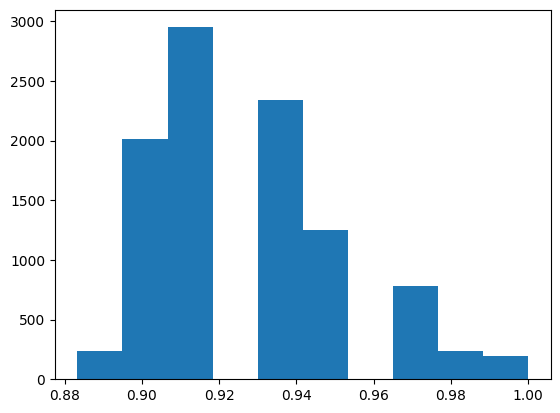

In [5]:
import matplotlib.pyplot as plt

plt.plot(quantiles)

In [7]:
from functools import partial

from flax import struct
from flax.training.train_state import TrainState
import optax

@struct.dataclass
class TrainConfig:
    batch_size: int = 200
    num_epochs: int = 3

    lr: float = 0.1


# Loss function
@partial(jax.value_and_grad, has_aux=True)
def compute_loss(params, apply_fn, X, Y):
    logits = apply_fn(params, X)
    preds = logits > 0

    loss = sigmoid_binary_cross_entropy(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc


def train_step(state: TrainState, batch):
    metrics, grads = compute_loss(state.params, state.apply_fn, *batch)
    return state.apply_gradients(grads=grads), metrics


@partial(jax.vmap, in_axes=(0, None, None, None, None, None, None))
def train(key, x_train, y_train, x_test, y_test, apply_fn, cfg: TrainConfig):
    params = model.init(key, x_train)

    # LR schedule
    num_steps = cfg.num_epochs * len(x_train) // cfg.batch_size
    sched = optax.cosine_decay_schedule(cfg.lr, num_steps)

    # Define the optimizer and training state
    tx = optax.sgd(learning_rate=sched, momentum=0.9)
    state = TrainState.create(apply_fn=apply_fn, params=params, tx=tx)

    # RNG key for each epoch
    keys = jax.vmap(jax.random.key)(jnp.arange(cfg.num_epochs))
    shape = x_train.shape[1:]

    def epoch_step(state: TrainState, key) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        # Re-shuffle the data at the start of each epoch
        indices = jax.random.permutation(key, len(x_train))
        data_, labels_ = x_train[indices], y_train[indices]

        # Create the batches
        X_batched = jnp.reshape(data_, (-1, cfg.batch_size, *shape))
        Y_batched = jnp.reshape(labels_, (-1, cfg.batch_size))

        return jax.lax.scan(train_step, state, (X_batched, Y_batched))

    state, _ = jax.lax.scan(epoch_step, state, keys)

    logits = apply_fn(state.params, x_test)
    test_acc = jnp.mean((logits > 0) == y_test)
    #test_loss = sigmoid_binary_cross_entropy(logits, y_test).mean(0)
    return test_acc #state.params, metrics

## Hessian

In [9]:
# @partial(jax.value_and_grad, has_aux=True)
# def compute_loss(params, apply_fn, X, Y):
#     logits = apply_fn(params, X)

model = MLP(hidden_sizes=(40,), out_features=1, param_dtype=dtype)

((loss, acc), grads) =compute_loss(model.init(jax.random.key(0), X_train[:1]), model.apply, X_train, Y_train)

In [17]:
grads['params'].keys()

dict_keys(['Dense_0', 'Dense_1'])

In [54]:
import jax.numpy as jnp
import jax.tree_util as tree

def flatten_params(params):
    """Flatten a nested dictionary of parameters into a 1D array."""
    flat, _ = tree.tree_flatten(params)
    return jnp.concatenate([p.ravel() for p in flat])

def unflatten_params(flat_params, ref_params):
    """Unflatten a 1D array into a nested dictionary of parameters."""
    flat_ref, treedef = tree.tree_flatten(ref_params)
    shapes = [p.shape for p in flat_ref]
    sizes = [p.size for p in flat_ref]
    
    unflattened = []
    idx = 0
    for shape, size in zip(shapes, sizes):
        unflattened.append(flat_params[idx:idx+size].reshape(shape))
        idx += size
    
    return tree.tree_unflatten(treedef, unflattened)

# Example usage:
params = model.init(jax.random.key(0), X_train[:1])
other_params = model.init(jax.random.key(1), X_train[:1])
flat_params = flatten_params(params)
unflat_params = unflatten_params(flat_params, other_params)

In [103]:
ref_params = model.init(jax.random.key(0), X_train[:1])
# Loss function

@partial(jax.hessian, has_aux=True)
def compute_loss_hessian(flat_params, apply_fn, X, Y):
    params = unflatten_params(flat_params, ref_params)
    logits = apply_fn(params, X)
    preds = logits > 0

    loss = sigmoid_binary_cross_entropy(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc

In [67]:
flat_params = flatten_params(model.init(jax.random.key(2), X_train[:1]))
hess, acc = compute_loss_hessian(flat_params, model.apply, X_train, Y_train)

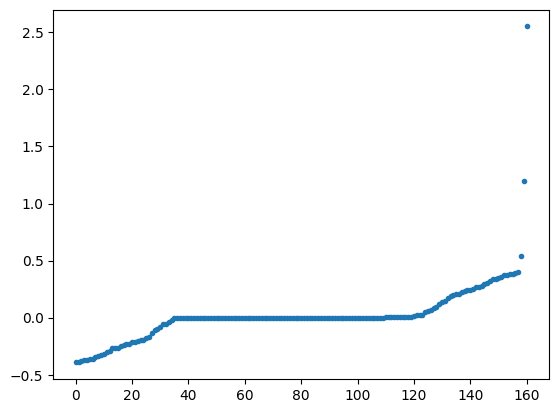

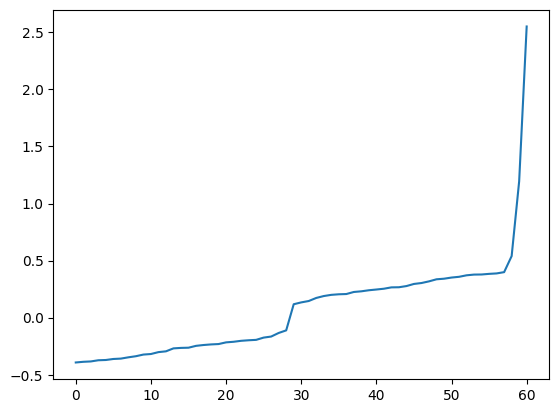

In [112]:
# convert dtype to float32
hess32 = jnp.array(hess, dtype=jnp.float32)
# jnp.linalg.eigvalsh(hess32)

plt.plot(jnp.linalg.eigvalsh(hess32), '.')
plt.show()

# plot all eigenvalues with abs > 0.1
plt.plot(jnp.linalg.eigvalsh(hess32)[jnp.abs(jnp.linalg.eigvalsh(hess32)) > 0.1])
plt.show()


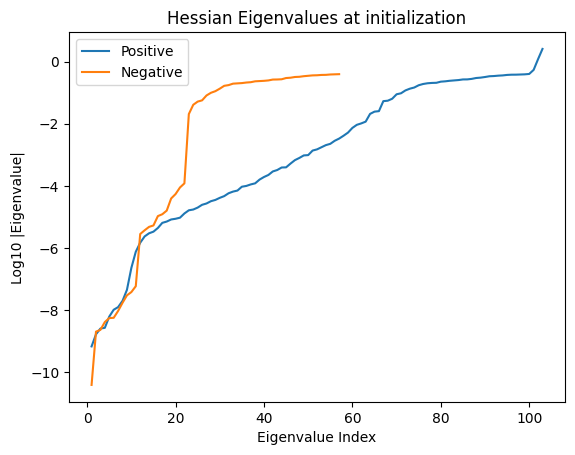

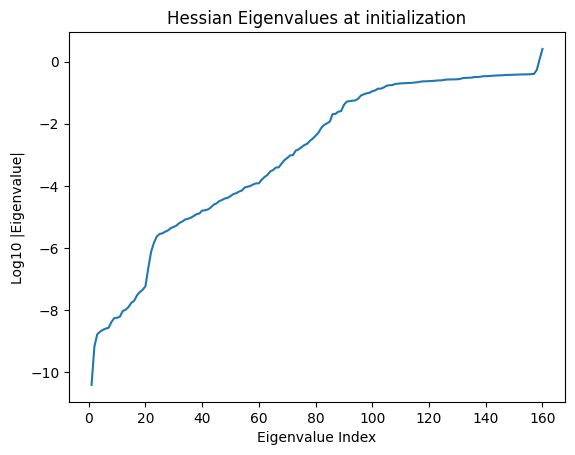

In [142]:
# abs, log, sort, plot
plt.plot(jnp.sort(jnp.log10(jnp.linalg.eigvalsh(hess32))), label="Positive")
plt.plot(jnp.sort(jnp.log10(-jnp.linalg.eigvalsh(hess32))), label="Negative")
plt.legend()
plt.xlabel("Eigenvalue Index")
plt.ylabel("Log10 |Eigenvalue|")
plt.title("Hessian Eigenvalues at initialization")
plt.show()

plt.plot(jnp.sort(jnp.log10(jnp.abs(jnp.linalg.eigvalsh(hess32)))))
plt.xlabel("Eigenvalue Index")
plt.ylabel("Log10 |Eigenvalue|")
plt.title("Hessian Eigenvalues at initialization")
plt.show()


In [126]:
dtype = jnp.bfloat16

def make_gnc_hessian(hidden_size):
    model = MLP(hidden_sizes=(hidden_size,), out_features=1, param_dtype=dtype)

    @partial(jax.vmap, in_axes=(0, None, None))
    def guess_and_check(key, x_test, y_test):
        params = model.init(key, x_test[:1])

        logits = model.apply(params, x_test)
        test_acc = jnp.mean((logits > 0) == y_test, axis=0)

        return test_acc

    @partial(jax.pmap, in_axes=(0, None, None))
    def batch_gnc(keys, X, Y):
        accs = guess_and_check(keys, X, Y)
        perfect_mask = accs == 1.0
        
        return jnp.mean(perfect_mask, dtype=jnp.float32), perfect_mask
    
    return model, batch_gnc

In [115]:
jax.random.key(4)

Array((), dtype=key<fry>) overlaying:
[0 4]

In [105]:
dtype = jnp.bfloat16
X_jax = jnp.array(X_nonlinear, dtype=dtype)
Y_jax = jnp.array(Y_nonlinear, dtype=dtype)



In [146]:
n_devices = len(jax.devices())


def compute_hessian_spectrum(flat_params, x_test, y_test):
    hess, _ = compute_loss_hessian(flat_params, model.apply, x_test, y_test)
    return jnp.linalg.eigvalsh(jnp.array(hess, dtype=jnp.float32))

def run_gnc_hessian(X, Y, hidden_size=40, iters=10):
    X_jax = jnp.array(X, dtype=dtype)
    Y_jax = jnp.array(Y, dtype=dtype)
    model, batch_gnc = make_gnc_hessian(hidden_size)

    hit_probs = []
    hessian_spectra = []
    spectra_counts = []

    hessian_spectra = []

    for i in trange(iters):
        keys = jax.random.split(jax.random.key(i), 1_000_000)
        keys = keys.reshape(n_devices, -1)
        hit_prob, perfect_masks = batch_gnc(keys, X_jax, Y_jax)
        good_keys = keys[perfect_masks]

        hit_probs.append(hit_prob)

        for key in good_keys:
            params = model.init(key, X_jax[:1])
            flat_params = flatten_params(params)
            hessian_spectrum = compute_hessian_spectrum(flat_params, X_jax, Y_jax)
            hessian_spectra.append(hessian_spectrum)
    
    return jnp.stack(hit_probs), jnp.stack(hessian_spectra)

In [134]:
probs, spectra = run_gnc_hessian(X_linear, Y_linear, 40)

100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


In [150]:
probs_nl, spectra_nl = run_gnc_hessian(X_nonlinear, Y_nonlinear, 40, 1_000)

100%|██████████| 1000/1000 [00:12<00:00, 81.38it/s]


In [152]:
spectra.shape, spectra_nl.shape

((1528, 161), (24, 161))

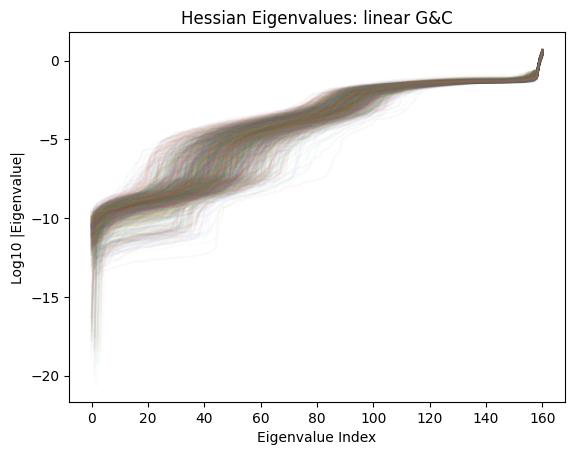

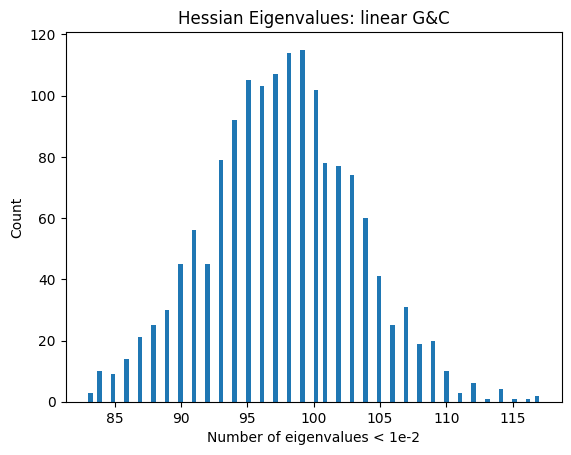

97.6911 +- 5.620305


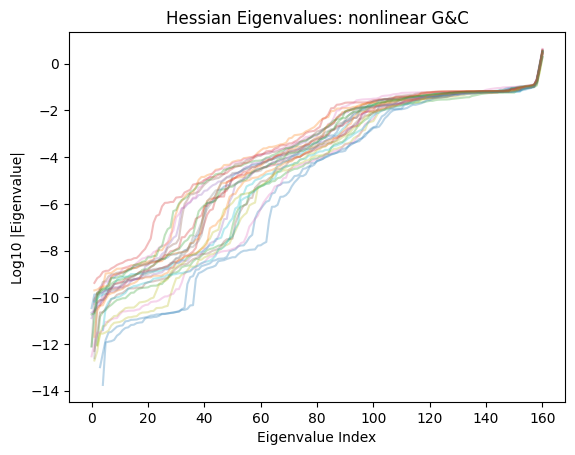

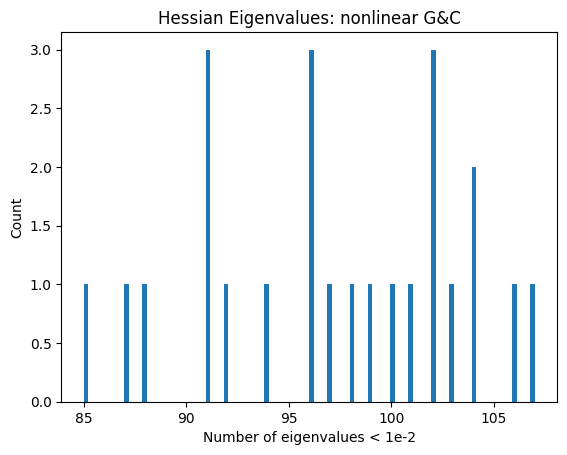

97.16667 +- 6.0873275


In [164]:
for i, spec in enumerate([spectra, spectra_nl]):
    for spectrum in spec:
        plt.plot(jnp.sort(jnp.log10(jnp.abs(spectrum))), alpha=0.03 * 10**i)
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Log10 |Eigenvalue|")
    plt.title(f"Hessian Eigenvalues: {['linear', 'nonlinear'][i]} G&C")
    plt.show()

    zeroes = jnp.sum(jnp.abs(spec) < 1e-2, axis=1)
    plt.hist(zeroes, bins=100)
    plt.xlabel("Number of eigenvalues < 1e-2")
    plt.ylabel("Count")
    plt.title(f"Hessian Eigenvalues: {['linear', 'nonlinear'][i]} G&C")
    plt.show()

    print(zeroes.mean(), "+-", zeroes.std())

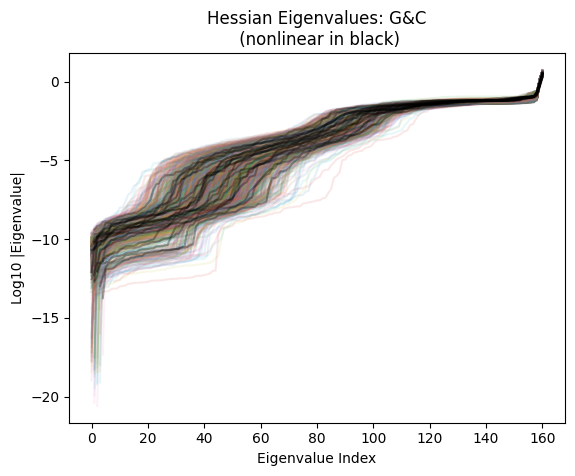

In [159]:
for spectrum in spectra:
    plt.plot(jnp.sort(jnp.log10(jnp.abs(spectrum))), alpha=0.1)
for spectrum in spectra_nl: # in red
    plt.plot(jnp.sort(jnp.log10(jnp.abs(spectrum))), alpha=0.5, color='black')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Log10 |Eigenvalue|")
plt.title(f"Hessian Eigenvalues: G&C\n (nonlinear in black)")
plt.show()

# zeroes = jnp.sum(jnp.abs(spec) < 1e-2, axis=1)
# plt.hist(zeroes, bins=100)
# plt.xlabel("Number of eigenvalues < 1e-2")
# plt.ylabel("Count")
# plt.title(f"Hessian Eigenvalues: {['linear', 'nonlinear'][i]} G&C")
# plt.show()

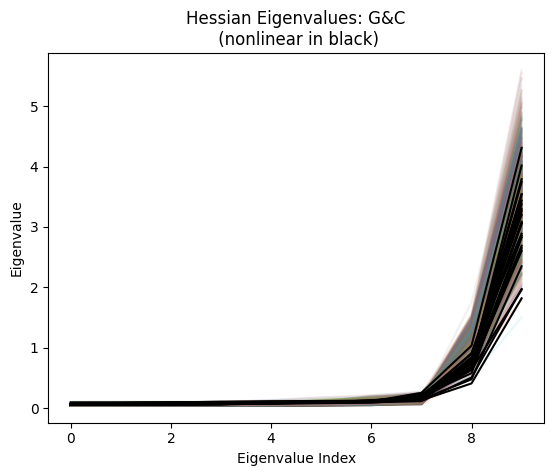

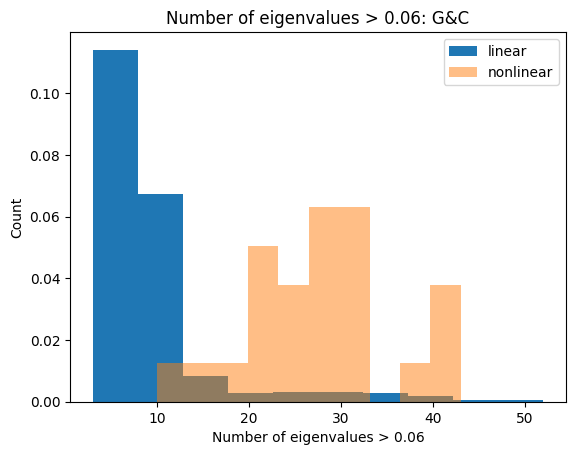

In [184]:
for spectrum in spectra:
    plt.plot(jnp.sort((spectrum))[-10:], alpha=0.1)
for spectrum in spectra_nl: # in red
    plt.plot(jnp.sort((spectrum))[-10:], alpha=1, color='black')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.title(f"Hessian Eigenvalues: G&C\n (nonlinear in black)")
plt.show()

# zeroes = jnp.sum(jnp.abs(spec) < 1e-2, axis=1)
# plt.hist(zeroes, bins=100)
# plt.xlabel("Number of eigenvalues < 1e-2")
# plt.ylabel("Count")
# plt.title(f"Hessian Eigenvalues: {['linear', 'nonlinear'][i]} G&C")
# plt.show()

thresh = 0.06
zeros = jnp.sum(jnp.abs(spectra) > thresh, axis=1)
plt.hist(zeros, label=f"linear", density=True)
zeros_nl = jnp.sum(jnp.abs(spectra_nl) > thresh, axis=1)
plt.hist(zeros_nl, alpha=0.5, label=f"nonlinear", density=True)
plt.legend()
plt.xlabel(f"Number of eigenvalues > {thresh}")
plt.ylabel("Count")
plt.title(f"Number of eigenvalues > {thresh}: G&C")
plt.show()


# # histogram of nth-largest eigenvalue
# for n in range(1, 10):
#     top = spectra[:, -n]
#     plt.hist(top, bins=100, label=f"linear", density=True)
#     top_nl = spectra_nl[:, -n]
#     plt.hist(top_nl, bins=10, alpha=0.5, label=f"nonlinear", density=True)
#     plt.legend()
#     plt.xlabel("Eigenvalue")
#     plt.ylabel("Count")
#     plt.title(f"{n}th Largest Eigenvalue: G&C")
#     plt.show()


## Training

/home/nora/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [04:16<00:00,  2.56s/it]


(array([  570751.,   746618.,  1340279.,  2130337.,  3094883.,  4333849.,
         6042496.,  8298547., 10760812., 13255668., 14421243., 18192018.,
        13389521.,  3362618.,    60360.]),
 array([0.53333336, 0.55111116, 0.5688889 , 0.5866667 , 0.6044445 ,
        0.62222224, 0.64000005, 0.65777785, 0.67555559, 0.69333339,
        0.71111119, 0.72888893, 0.74666673, 0.76444453, 0.78222227,
        0.80000007]),
 <BarContainer object of 15 artists>)

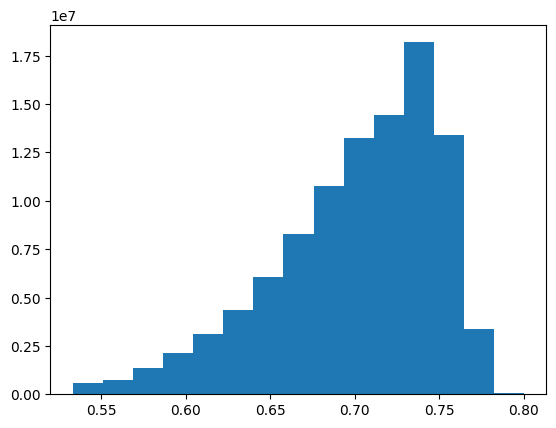

In [6]:
from tqdm.auto import trange

@jax.pmap
def train_fn(keys):
    return train(keys, jnp.array(X_train), jnp.array(Y_train), jnp.array(X_nonlinear), jnp.array(Y_nonlinear), model.apply, TrainConfig())

accs = []
for i in trange(100):
    keys = jax.random.split(jax.random.key(i), 1_000_000)
    accs.append(train_fn(keys.reshape(4, -1)))

accs = jnp.concatenate(accs).flatten()
import matplotlib.pyplot as plt
plt.hist(accs, bins=15)

In [7]:
accs.max()

Array(0.8000001, dtype=float32)

Text(0, 0.5, 'Linear Acc')

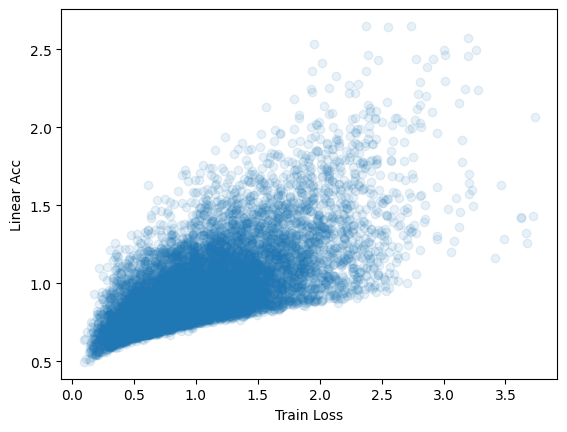

In [20]:
import matplotlib.pyplot as plt

plt.scatter(loss_train, acc_linear, alpha=0.1)
plt.xlabel("Train Loss")
plt.ylabel("Linear Acc")